# [Implementation and application patterns for explaining methods]()
-------
#### Software chapter of the "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning" book 
--------

This is the accompanying code for the software chapter of the book "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning". For a more detailed understanding please have a look into the chapter: [TODO: Add link.]().

-------

## Section 2


Load all modules and initialize the backend.

In [1]:
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
import imp
import numpy as np
import matplotlib
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', family = 'serif', size=17)
import matplotlib.pyplot as plot
import os
import skimage.segmentation
import sklearn.linear_model
import sklearn.metrics
import tensorflow as tf

import keras
import keras.backend
import keras.layers
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.layers as ilayers
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph

from innvestigate.analyzer import ReverseAnalyzerBase
from innvestigate.analyzer.relevance_based import relevance_rule as LRPRules

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source('utils', '../utils.py')
imgnetutils = imp.load_source('utils_imagenet', '../utils_imagenet.py')

# Get session for native TF code
assert keras.backend.backend() == 'tensorflow'
sess = keras.backend.get_session()

Using TensorFlow backend.


Load the VGG16 network and set image conversion parameters.

In [3]:
# Load the model definition.
tmp = getattr(innvestigate.applications.imagenet, 'vgg16')
net = tmp(load_weights=True, load_patterns=True)

# Build the model.
model = keras.models.Model(inputs=net['in'], outputs=net['sm_out'])
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == 'channels_first'
if channels_first:
    channel_axis = 1
else:
    channel_axis = 3
color_conversion = 'BGRtoRGB' if net['color_coding'] == 'BGR' else None

# This a convience function to wrap mapping implemented in TF into a Keras layer.
def tf_to_keras_mapping(f):
    
    def wrapper(Xs, Ys, bp_Ys, bp_state):
        def inner_wrapper(tensors):
            X, Y, bp_Y = tensors
            return f(X, Y, bp_Y, bp_state)
        
        X, Y, bp_Y = Xs[0], Ys[0], bp_Ys[0]
        output_shape = keras.backend.int_shape(X)
        return keras.layers.Lambda(inner_wrapper, output_shape=output_shape)([X, Y, bp_Y])
    
    return wrapper

We want to analyze the pre-softmax activations:

In [4]:
# Create model without trailing softmax
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

# Get TF tensors
input, output = model_wo_sm.inputs[0], model_wo_sm.outputs[0]
# Reduce output to response of neuron with largest activation
max_output = tf.reduce_max(output, axis=1)

Finally, we load also one sample image:

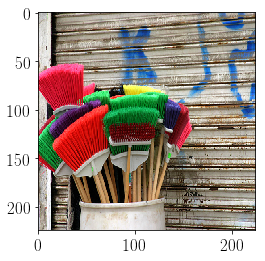

In [5]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(net['image_shape'][0])

if not len(images):
    raise Exception('Please download the example images using: '
                    '\'innvestigate/examples/images/wget_imagenet_2011_samples.sh\'')

# Choose a sample image and add batch axis
x_not_pp = images[3][0][None, :, :, :]
# Preprocess it for VGG16
x = imgnetutils.preprocess(x_not_pp, net)
# Displaying the image
plot.imshow(x_not_pp[0]/255)
plot.show()

## Section 2.2

### Example A1: input times gradient

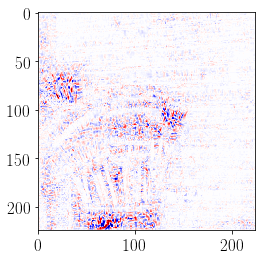

In [6]:
# Take gradient of output neuron w.r.t. to input
gradient = tf.gradients(max_output, input)[0]
# and multiply it with the input
input_t_gradient = input * gradient
# Run the code with TF
A1 = sess.run(input_t_gradient, {input: x})

# Postprocess
a = A1
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Example A2: Integrated Gradients

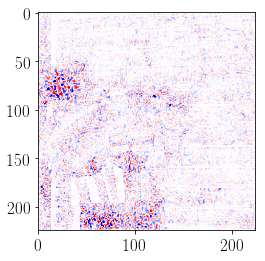

In [7]:
# Nr. of steps along path
steps = 16
# Take as reference a black image,
# i.e., lowest number networks input value range.
x_ref = np.ones_like(x) * net['input_range'][0]
# Take gradient of output neuron w.r.t. to input
gradient = tf.gradients(max_output, input)[0]

# Sum gradients along the path from x to x_ref
gradient_sum = np.zeros_like(x)
for step in range(steps):
    # Create intermediate input
    x_step = x_ref + (x - x_ref) * step / steps
    # Compute and add the gradient for intermediate input
    gradient_sum += sess.run(gradient, {input: x_step})

# Integrated Gradients formula
A2 = gradient_sum * (x - x_ref)

# Postprocess
a = A2
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Example A3: Occlusion

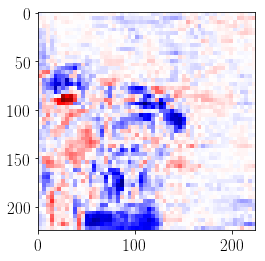

In [8]:
A3 = np.zeros_like(x)
# Choose a patch size
psize = 4

# Occlude patch by patch and calculate activation for each patch
for i in range(0, net['image_shape'][0], psize):
    for j in range(0, net['image_shape'][0], psize):
        
        # Create image with the patch occluded
        occluded_x = x.copy()
        occluded_x[:, i:i+psize, j:j+psize, :] = 0
        
        # Store activation of occluded image
        A3[:, i:i+psize, j:j+psize, :] = sess.run(max_output, {input: occluded_x})[0]

# Normalize with initial activation value
A3 -= sess.run(max_output, {input: x})[0]

# Postprocess
a = A3
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Example A4: LIME

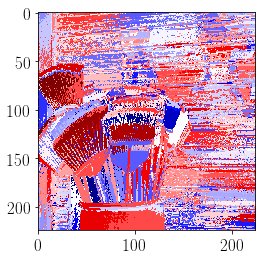

In [9]:
# Segment (not pre-processed) image
segments = skimage.segmentation.quickshift(
    x_not_pp[0], kernel_size=4, max_dist=200, ratio=0.2)
nr_segments = np.max(segments)+1

# Create dataset
nr_samples = 1000
# Randomly switch segments on and off
features = np.random.randint(0, 2, size=(nr_samples, nr_segments))
features[0, :] = 1

# Get labels for features
labels = []
for sample in features:
    tmp = x.copy()
    # Switch segments on and off
    for segment_id, segment_on in enumerate(sample):
        if segment_on == 0:
            tmp[0][segments == segment_id] = (0, 0, 0)
    # Get predicted value for this sample
    labels.append(sess.run(max_output, {input: tmp})[0])

# Compute sample weights
distances = sklearn.metrics.pairwise_distances(
            features,
            features[0].reshape(1, -1),
            metric='cosine',
).ravel()
kernel_width = 0.25
sample_weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

# Fit L1-regressor
regressor = sklearn.linear_model.Ridge(alpha=1, fit_intercept=True)
regressor.fit(features, labels, sample_weight=sample_weights)
weights = regressor.coef_


# Map weights onto segments
A4 = np.zeros_like(x)
for segment_id, w in enumerate(weights):
    A4[0][segments == segment_id] = (w, w, w)


# Postprocess
a = A4
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Example B1: Guided Backprop

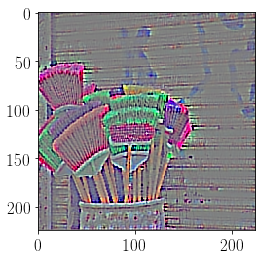

In [10]:
# Guidded-Backprop-Mapping
# X = input tensor of layer
# Y = ouput tensor of layer
# bp_Y = backpropgated value for Y
# bp_state = additional information on state
def guided_backprop_mapping(X, Y, bp_Y, bp_state):
    # Apply ReLU to back-propagate values
    tmp = tf.nn.relu(bp_Y)
    # Propagate back along the gradient of the forward pass
    return tf.gradients(Y, X, grad_ys=tmp)

# Extending iNNvestigate base class with the Guideded Backprop code
class GuidedBackprop(ReverseAnalyzerBase):

    # Register the mapping for layers that contain a ReLU
    def _create_analysis(self, *args, **kwargs):

        self._add_conditional_reverse_mapping(
            # Apply to all layers that contain a relu activation
            lambda layer: kchecks.contains_activation(layer, 'relu'),
            # and use the guided_backprop_mapping to do the backrop step.
            tf_to_keras_mapping(guided_backprop_mapping),
            name='guided_backprop',
        )

        return super(GuidedBackprop, self)._create_analysis(*args, **kwargs)

# Creating an instance of that analyzer
analyzer = GuidedBackprop(model_wo_sm)
# and apply it.
B1 = analyzer.analyze(x)

# Postprocess
a = B1
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.bk_proj(a)[0])
plot.show()

### Example B2a: Deep Taylor / LRP-Z

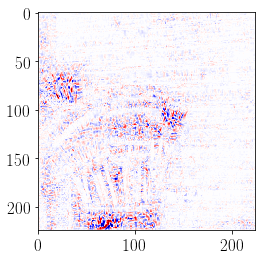

In [11]:
# Deep-Taylor/LRP's Z-Rule-Mapping for dense layers
# Call R=bp_Y, R for relevance
def z_rule_mapping_dense(X, Y, R, bp_state):
    # Get layer and the parameteres
    layer = bp_state['layer']
    W, b = layer.kernel, layer.bias

    Z = tf.tensordot(X, W, 1) + b
    # normalize incoming relevance
    tmp = R / Z
    # map back
    tmp = tf.tensordot(tmp, tf.transpose(W), 1)
    # times input
    return tmp * X

# Deep-Taylor/LRP's Z-Rule-Mapping for conv layers
# Call R=bp_Y, R for relevance
def z_rule_mapping_conv(X, Y, R, bp_state):
    # Get layer and the parameteres
    layer = bp_state['layer']
    W, b = layer.kernel, layer.bias

    Z = tf.keras.backend.conv2d(X, W, layer.strides, layer.padding) + b
    # normalize incoming relevance
    tmp = R / Z
    # map back
    tmp = tf.keras.backend.conv2d_transpose(
        tmp, W, (1,)+keras.backend.int_shape(X)[1:], layer.strides, layer.padding)
    # times input
    return tmp * X


# Extending iNNvestigate base class with the Deep Taylor/LRP's Z-rule
class DeepTaylorZ1(ReverseAnalyzerBase):

    # Register the mappings
    def _create_analysis(self, *args, **kwargs):

        self._add_conditional_reverse_mapping(
            # Apply to all dense layers
            lambda layer: isinstance(layer, keras.layers.Dense),
            tf_to_keras_mapping(z_rule_mapping_dense),
            name='z-rule-dense',
        )
        self._add_conditional_reverse_mapping(
            # Apply to all conv2d layers
            lambda layer: isinstance(layer, keras.layers.Conv2D),
            tf_to_keras_mapping(z_rule_mapping_conv),
            name='z-rule-conv',
        )

        return super(DeepTaylorZ1, self)._create_analysis(*args, **kwargs)

analyzer = DeepTaylorZ1(model_wo_sm)
B2a = analyzer.analyze(x)

# Postprocess
a = B2a
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Example B2b: Deep Taylor with AutoGrad

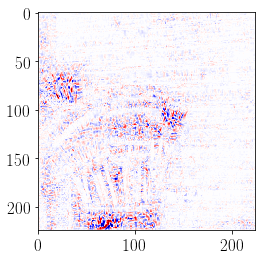

In [12]:
# Deep-Taylor/LRP's Z-Rule-Mapping for all layers with a kernel
# Call R=bp_Y, R for relevance
def z_rule_mapping_all(X, Y, R, bp_state):
    # Get layer
    layer = bp_state['layer']
    # and create layer copy without activation part
    layer_wo_act = kgraph.copy_layer_wo_activation(layer)

    Z = layer_wo_act(X)
    # normalize incoming relevance
    tmp = R / Z
    # map back
    tmp = tf.gradients(Z, X, grad_ys=tmp)[0]
    # times input
    return tmp * X


# Extending iNNvestigate base class with the Deep Taylor/LRP's Z-rule
class DeepTaylorZ2(ReverseAnalyzerBase):

    # Register the mappings
    def _create_analysis(self, *args, **kwargs):

        self._add_conditional_reverse_mapping(
            # Apply to all layers that contain a kernel
            lambda layer: kchecks.contains_kernel(layer),
            tf_to_keras_mapping(z_rule_mapping_all),
            name='z-rule',
        )

        return super(DeepTaylorZ2, self)._create_analysis(*args, **kwargs)


analyzer = DeepTaylorZ2(model_wo_sm)
B2b = analyzer.analyze(x)

# Postprocess
a = B2b
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Example B3: LRP with several rules

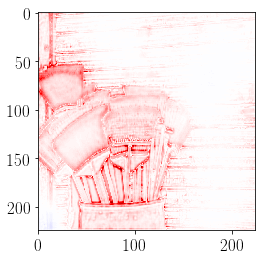

In [13]:
class LRPPresetA(ReverseAnalyzerBase):

    # Register the mappings for different layer types
    def _create_analysis(self, *args, **kwargs):

        # Use Epsilon rule for dense layers
        self._add_conditional_reverse_mapping(
            lambda layer: kchecks.is_dense_layer(layer),
            LRPRules.EpsilonRule,
            name='dense',
        )
        # Use Alpha1Beta0 rule for conv layers
        self._add_conditional_reverse_mapping(
            lambda layer: kchecks.is_conv_layer(layer),
            LRPRules.Alpha1Beta0Rule,
            name='conv',
        )

        return super(LRPPresetA, self)._create_analysis(*args, **kwargs)

analyzer = LRPPresetA(model_wo_sm)
B3 = analyzer.analyze(x)

# Postprocess
a = B3
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Example B4 and B5: PatternNet and PatternAttribution

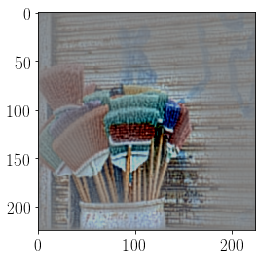

In [14]:
# Extending iNNvestigate base class with the PatternNet algorithm
class PatternNet(ReverseAnalyzerBase):

    # Storing the patterns.
    def __init__(self, model, patterns, **kwargs):
        self._patterns = patterns[:]
        super(PatternNet, self).__init__(model, **kwargs)
        
    def _get_pattern_for_layer(self, layer):
        return self._patterns.pop(-1)

    def _patternnet_mapping(self, X, Y, bp_Y, bp_state):
        # Get layer,
        layer = bp_state['layer']
        # exchange kernel weights with patterns,
        weights = layer.get_weights()
        weights[0] = self._get_pattern_for_layer(layer)
        # and create layer copy without activation part and patterns as filters
        layer_wo_act = kgraph.copy_layer_wo_activation(layer, weights=weights)

        if kchecks.contains_activation(layer, 'relu'):
            # Gradient of activation layer
            tmp = tf.where(Y > 0, bp_Y, tf.zeros_like(bp_Y))
        else:
            # Gradient of linear layer
            tmp = bp_Y

        # map back along layer with patterns instead of weights
        pattern_Y = layer_wo_act(X)
        return tf.gradients(pattern_Y, X, grad_ys=tmp)[0]
    
    # Register the mappings
    def _create_analysis(self, *args, **kwargs):

        self._add_conditional_reverse_mapping(
            # Apply to all layers that contain a kernel
            lambda layer: kchecks.contains_kernel(layer),
            tf_to_keras_mapping(self._patternnet_mapping),
            name='pattern_mapping',
        )

        return super(PatternNet, self)._create_analysis(*args, **kwargs)


analyzer = PatternNet(model_wo_sm, net['patterns'])
B4 = analyzer.analyze(x)

# Postprocess
a = B4[:]
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.bk_proj(a)[0])
plot.show()

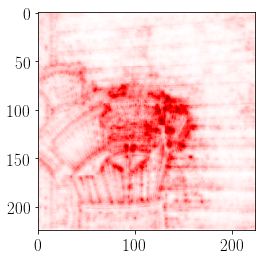

In [15]:
# Extending PatternNet to PatternAttribution
class PatternAttribution(PatternNet):

    def _get_pattern_for_layer(self, layer):
        filters = layer.get_weights()[0]
        patterns = self._patterns.pop(-1)
        return filters * patterns

analyzer = PatternAttribution(model_wo_sm, net['patterns'])
B5 = analyzer.analyze(x)

# Postprocess
a = B5
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the explanation
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

### Graphic for paper

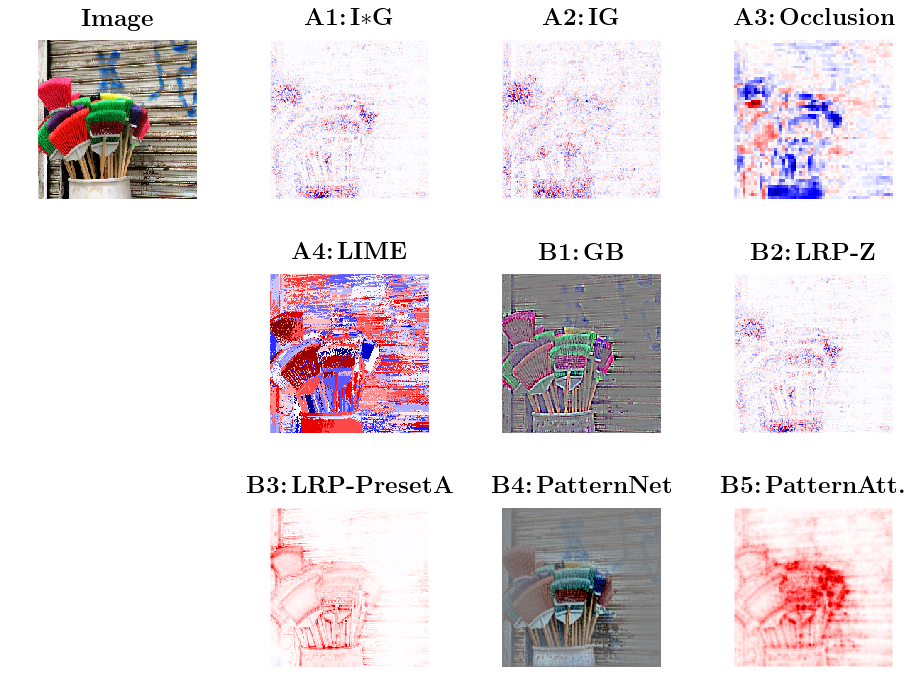

In [16]:
plot.figure(figsize=(13, 10))
plot_sequence = [
    (x_not_pp, 1, r'\textbf{Image}', lambda tmp: tmp/255),
    (A1, 2, r'\textbf{A1:$\,$I$*$G}', imgnetutils.heatmap),
    (A2, 3, r'\textbf{A2:$\,$IG}', imgnetutils.heatmap),
    (A3, 4, r'\textbf{A3:$\,$Occlusion}', imgnetutils.heatmap),
    (A4, 6, r'\textbf{A4:$\,$LIME}', imgnetutils.heatmap),
    (B1, 7, r'\textbf{B1:$\,$GB}', imgnetutils.bk_proj),
    (B2b, 8, r'\textbf{B2:$\,$LRP-Z}', imgnetutils.heatmap),
    (B3, 10, r'\textbf{B3:$\,$LRP-PresetA}', imgnetutils.heatmap),
    (B4, 11, r'\textbf{B4:$\,$PatternNet}', imgnetutils.bk_proj),
    (B5, 12, r'\textbf{B5:$\,$PatternAtt.}', imgnetutils.heatmap),
]

for plot_x, plot_id, title, postp_f in plot_sequence:
    ax = plot.subplot(3, 4, plot_id)
    ax.annotate(title, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', weight='semibold', ha='center', va='baseline')
    #ax.set_title(title)
     
    if plot_id != 1:
        plot_x = imgnetutils.postprocess(plot_x, color_conversion, channels_first)
    ax.imshow(postp_f(plot_x)[0])
    ax.axis('off')

plot.tight_layout()
plot.savefig("swchapter_implementations.pdf")
plot.show()

## Section 2.3

### Hyperpareter: Baselines

In [17]:
IG = []
# Take 5 samples from network's input value range
for ri in np.linspace(net['input_range'][0], net['input_range'][1], num=5):
    # and analyze with each.
    analyzer = innvestigate.create_analyzer(
        'integrated_gradients',
        model_wo_sm,
        reference_inputs=ri,
        steps=32
    )
    IG.append(analyzer.analyze(x))

<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>


### Hyperparameter: Sensitivy

In [18]:
SG1, SG2 = [], []
# Take 5 scale samples for the noise scale of smoothgrad.
for scale in range(5):
    noise_scale = (net['input_range'][1]-net['input_range'][0]) * scale / 5
    # Smoothgrad with absolute gradients
    analyzer = innvestigate.create_analyzer(
        'smoothgrad',
        model_wo_sm,
        augment_by_n=32,
        noise_scale=noise_scale,
        postprocess='abs'
    )
    SG1.append(analyzer.analyze(x))

    # Smoothgrad with with squared gradients
    analyzer = innvestigate.create_analyzer(
        'smoothgrad',
        model_wo_sm,
        augment_by_n=32,
        noise_scale=noise_scale,
        postprocess='square'
    )
    SG2.append(analyzer.analyze(x))

<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>
<class 'list'> <class 'list'>


### Graphic for paper

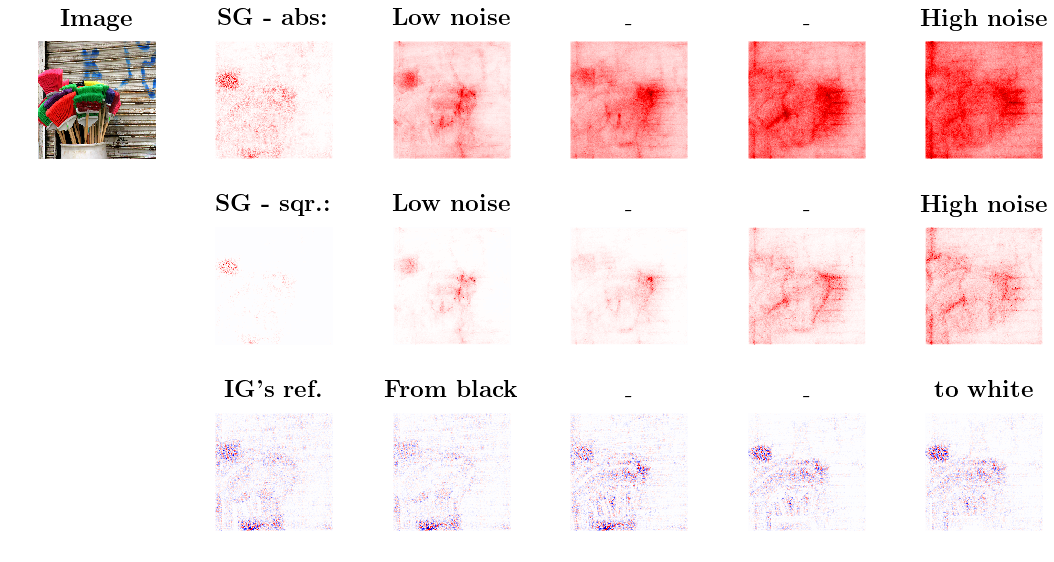

In [19]:
plot.figure(figsize=(15, 8))
plot_sequence = [
    (x_not_pp, (3, 6, 1), r'\textbf{Image}', lambda x: x/255),
]

title = [r'\textbf{SG - abs:}', r'\textbf{Low noise}', '-', '-', r'\textbf{High noise}']
plot_sequence += [(SG1[i], (3, 6, 2+i), title[i], imgnetutils.heatmap) for i in range(5)]
title = [r'\textbf{SG - sqr.:}', r'\textbf{Low noise}', '-', '-', r'\textbf{High noise}']
plot_sequence += [(SG2[i], (3, 6, 8+i), title[i], imgnetutils.heatmap) for i in range(5)]
title = [r"\textbf{IG's ref.}", r'\textbf{From black}', '-', '-', r'\textbf{to white}']
plot_sequence += [(IG[i], (3, 6, 14+i), title[i], imgnetutils.heatmap) for i in range(5)]

for plot_x, plot_id, title, postp_f in plot_sequence:
    ax = plot.subplot(*plot_id)
    ax.annotate(title, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', weight='semibold', ha='center', va='baseline')
    #ax.set_title(title)
    
    x_plot = imgnetutils.postprocess(plot_x, color_conversion, channels_first)
    ax.imshow(postp_f(plot_x)[0])
    ax.axis('off')

plot.tight_layout()
plot.savefig("swchapter_hyperparamter.pdf")
plot.show()

### Visualizations

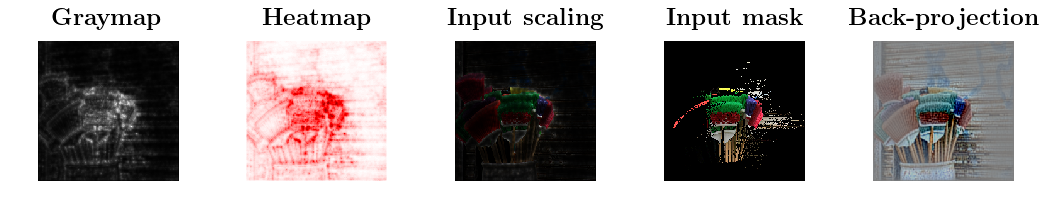

In [20]:
analyses = [B5, B5, B5, B5, B4]

def scale_input(x):
    x = np.sum(np.abs(x), axis=channel_axis, keepdims=True)
    x_max = np.max(x)
    scale = x / x_max

    ret = (x_not_pp / 255) * scale
    return ret


def mask_input(x):
    # Get highest scored segments
    segments_scored = [(np.max(x[0][segments == sid]), sid) for sid in range(nr_segments)]
    highest_ones = sorted(segments_scored, reverse=True)[:50]
    # Compute mask
    mask = np.zeros_like(segments)
    for _, sid in highest_ones:
        mask[segments == sid] = 1
    # Apply mask
    ret = (x_not_pp.copy() / 255)
    ret[0][mask == 0] = 0
    return ret

visualization_functions = [
    (r"\textbf{Graymap}", lambda x: imgnetutils.graymap(np.abs(x))),
    (r"\textbf{Heatmap}", imgnetutils.heatmap),
    (r"\textbf{Input scaling}", scale_input),
    (r"\textbf{Input mask}", mask_input),
    (r"\textbf{Back-projection}", imgnetutils.bk_proj),
]

plot.figure(figsize=(15, 3))
rows = 1
cols = len(analyses)

for i, ((vis_name, vis_f), analysis) in enumerate(zip(visualization_functions, analyses)):
    ax = plot.subplot(*(rows, cols, i+1))
    ax.annotate(vis_name, xy=(0.5, 1), xytext=(0, 15),
        xycoords='axes fraction', textcoords='offset points',
        size='x-large', weight='semibold', ha='center', va='baseline')

    tmp = imgnetutils.postprocess(analysis, color_conversion, channels_first)
    ax.imshow(vis_f(tmp)[0])
    ax.axis('off')

plot.tight_layout()
plot.savefig("swchapter_visualizations.pdf")
plot.show()